# N-body system

Consider a system of $N$ bodies under gravitational attraction. The masses are $(m_i)_{i\in I}$ and the gravitational constant is ${\mathcal G}$. The problem is to study and represent the motion of this system.

We use standard (Euclidian) coordinates $(x_i,y_i)_{i\in I}$ in some arbitrary inertial frame of reference.

The equations of the dynamics are given by:

\begin{equation*}
\left\{
\begin{array}{rcl}
\ddot{x_i} & = &
\sum_{j\not=i}{\mathcal G}m_j((x_j-x_i)^2+(y_j-y_i)^2)^{-\frac{3}{2}}(x_j-x_i)
\\
\ddot{y_i} & = &
\sum_{j\not=i}{\mathcal G}m_j((x_j-x_i)^2+(y_j-y_i)^2)^{-\frac{3}{2}}(y_j-y_i)
\end{array}
\right.
\end{equation*}

Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5

import logging
from functools import partial
from ipyshow import Setup
from ipyshow.odesimu import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


In [2]:
#----------------------------------------------------------------------------------------------------
class GNbody (System):
#----------------------------------------------------------------------------------------------------

  @Setup(
    'ML: list of masses of the bodies [kg]',
    'G: gravitational constant [m^3.kg^-1.sec^-2]',
  )
  def __init__(self,*ML,G=None):
    self.ML,self.G = ML,G
    N = len(ML)
    MM = array(ML)*G
    ID = eye(N,dtype=bool)
    slices = slice(None,N),slice(N,2*N)
    slicesd = slice(2*N,3*N),slice(3*N,None)
    self.shadowshape = (N,2)
    def main(t,state,a=zeros((2,N,N),dtype=float),b=zeros((1,N,N),dtype=float)):
      r = state.copy()
      for s,v,sd in zip(slices,a,slicesd):
        z = state[s]
        v[...] = z[newaxis,:]-z[:,newaxis]
        r[s] = state[sd]
      b[0,...] = sum(square(a),axis=0,keepdims=True)
      b *= sqrt(b)
      b[0][ID] = 1.
      a /= b
      for s,v in zip(slicesd,a): dot(v,MM,r[s])
      return r
    self.main = main
    def fordisplay(state):
      x,y = (state[s] for s in slices)
      live = tuple(zip(x,y))
      return live, live
    self.fordisplay = fordisplay

  def display(self,ax,refsize=50.,**ka):
    diag_s = ax.scatter((),(),s=refsize,marker='o',c='b')
    tails_l = tuple(ax.plot((),(),'y')[0] for m in self.ML)
    ax.set_title('trajectory:?')
    def disp(t,live,tail):
      diag_s.set_offsets(live)
      for t_l,xy in zip(tails_l,swapaxes(tail,0,1)): t_l.set_data(xy[:,0],xy[:,1])
      ax.relim()
      ax.autoscale_view()
    return super().display(ax,disp,**ka)

  @Setup(
      'xydxdyL: list of quadruple with xy-position and speed',
  )
  def makestate(self,*xydxdyL):
    assert len(xydxdyL)==len(self.ML)
    for u in xydxdyL: assert len(u)==4
    return concatenate(list(zip(*xydxdyL)))

  @Setup(
    System.launch,
    'refsize: average size (area) of the bodies for display [pt^2]',
    taild=10,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

In [3]:
Setup.display(GNbody)

**** GNbody.__init__(self, *ML, G=None) ****
    ML        : list of masses of the bodies [kg]
    G         : gravitational constant [m^3.kg^-1.sec^-2]
**** GNbody.launch(self, *a, **ka) ****
    maxtime   (inf       ): total simulation time length [sec]
    srate     (25.0      ): sampling rate [sec^-1]
    taild     (10        ): shadow duration [sec]
    hooks     ((functools): tuple of display hooks []
    ini       : initial state []
    refsize   : average size (area) of the bodies for display [pt^2]
**** GNbody.makestate(self, *xydxdyL) ****
    xydxdyL   : list of quadruple with xy-position and speed []

<IPython.core.display.Javascript object>


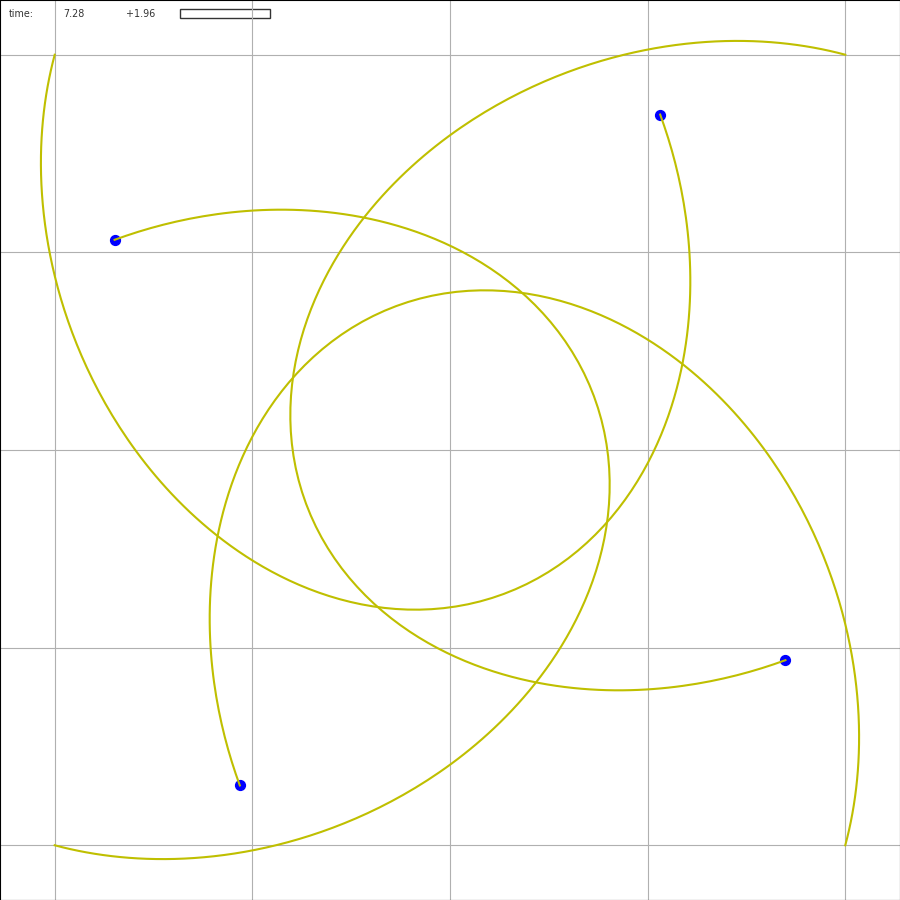

In [4]:
logging.basicConfig(level='WARN') # can be changed dynamically by logger_hook
syst = GNbody(10,10,10,10,G=1)
v = 1; u = 4; a = -pi/12; d = 0.
#v = 1; u = 4; a = -pi/12; d = .005
ini = (
  (-u,-u,v*cos(a),v*sin(a)),
  (u,-u,-v*sin(a),v*cos(a)),
  (u,u,-v*cos(a),-v*sin(a)),
  (-u,u,v*sin(a),d-v*cos(a)),
)
syst.launch(ini=syst.makestate(*ini))